# Fine-tuning Classifier LLM


In [1]:
!pip install optuna
!pip install typing
!pip install evaluate
!pip install torch
!pip install transformers
!pip install accelerate>=0.26.0

  Using cached evaluate-0.4.5-py3-none-any.whl.metadata (9.5 kB)
Using cached evaluate-0.4.5-py3-none-any.whl (84 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia

In [2]:
# setup - load packages
import pandas as pd
from datasets import Dataset, load_dataset
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from typing import Union, Mapping, List, Dict, Any
import evaluate
from tqdm import tqdm
import zipfile
import os
from sklearn.utils.class_weight import compute_class_weight

# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

seed = 13

cuda


## VERSION A

In [3]:
classifier_data = pd.read_csv("/content/classifier_data_A.csv")
# converting to huggingface dataset format
data = Dataset.from_pandas(classifier_data)
# splitting into train, test and validation sets

label_names = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'AfD', 'LINKE']
label2id = {label: i for i, label in enumerate(sorted(label_names))}
id2label = {i: label for label, i in label2id.items()}
def map_labels(example):
    example["label"] = label2id[example["label"]]
    return example
data = data.map(map_labels)


# shuffling data
raw_dataset = data.shuffle(seed=seed)

# 70% train, 15% test, 15% validation data
split = raw_dataset.train_test_split(test_size=0.3, seed=seed)
train_data = split["train"]
text_and_val_data = split["test"]
split = text_and_val_data.train_test_split(test_size=0.5, seed=seed)
test_data = split["train"]
val_data = split["test"]

print(f"Training samples party: {len(train_data)}")
print(f"Test samples party: {len(test_data)}")
print(f"Validation samples party: {len(val_data)}")



Map:   0%|          | 0/36117 [00:00<?, ? examples/s]

Training samples party: 25281
Test samples party: 5418
Validation samples party: 5418


In [4]:
# compute class weights
# Get raw labels as a list of integers
all_train_labels = train_data["label"]

# Compute unique class values
unique_labels = np.unique(all_train_labels)

# Compute weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=unique_labels,
    y=all_train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights

tensor([1.1977, 0.6153, 1.2799, 1.1866, 1.7240, 0.7487])

In [5]:
WINDOW_LENGTH = 512
STRIDE = 256

In [6]:
# Load Tokenizer
model_name = "deepset/gbert-base"
num_labels = 6
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    model_max_length=WINDOW_LENGTH
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [7]:
def sliding_window_tokenize(batch):
    texts = batch["speech_text"]
    labels = batch["label"]  # ensure this is a flat list of ints

    tokenized = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=WINDOW_LENGTH,
        stride=STRIDE,
        return_overflowing_tokens=True,
    )

    # Assign each overflow window the correct label
    #tokenized["labels"] = [label2id[labels[i]] for i in tokenized["overflow_to_sample_mapping"]]
    tokenized["labels"] = [labels[i] for i in tokenized["overflow_to_sample_mapping"]]

    return tokenized


In [8]:
tokenized_train_data = train_data.map(
    sliding_window_tokenize,
    batched=True,
    remove_columns=train_data.column_names
)

tokenized_val_data = val_data.map(
    sliding_window_tokenize,
    batched=True,
    remove_columns=train_data.column_names
)



Map:   0%|          | 0/25281 [00:00<?, ? examples/s]

Map:   0%|          | 0/5418 [00:00<?, ? examples/s]

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(
    "deepset/gbert-base",
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id
)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]

    return {
        "accuracy": acc,
        "f1": f1
    }


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from transformers import Trainer
import torch.nn.functional as F

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.model.device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        return (loss, outputs) if return_outputs else loss


## Training with best Tuning Parameters


In [11]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_val_data,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

trainer.train()


/tmp/ipython-input-1098611646.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.775800,0.764789,0.714361,0.713515
2,0.463100,0.735462,0.746496,0.746519
3,0.254500,0.838902,0.756348,0.752549


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=13302, training_loss=0.5824320427082011, metrics={'train_runtime': 6210.179, 'train_samples_per_second': 34.27, 'train_steps_per_second': 2.142, 'total_flos': 5.599809519986074e+16, 'train_loss': 0.5824320427082011, 'epoch': 3.0})

In [12]:
model.save_pretrained("classifier_final_A/")
tokenizer.save_pretrained("classifier_final_A/")

('classifier_final_A/tokenizer_config.json',
 'classifier_final_A/special_tokens_map.json',
 'classifier_final_A/vocab.txt',
 'classifier_final_A/added_tokens.json',
 'classifier_final_A/tokenizer.json')

In [13]:
# model und tokenizer müssen schon geladen sein
model.eval()

def tokenize_sliding_windows(example: Dict[str, Any]) -> Dict[str, Any]:
    encoding = tokenizer(
        example["speech_text"],
        truncation=True,
        padding="max_length",
        max_length=WINDOW_LENGTH,
        stride=STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=False,
        return_tensors="pt"
    )
    return encoding

def predict_proba_for_dataset(dataset: Dataset, label_names) -> List[Dict[str, Any]]:
    results = []

    for example in tqdm(dataset):
        tokenized = tokenize_sliding_windows(example)
        input_ids = tokenized["input_ids"].to(model.device)
        attention_mask = tokenized["attention_mask"].to(model.device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

        avg_probs = probs.mean(axis=0)
        pred_idx = int(np.argmax(avg_probs))
        pred_label = label_names[pred_idx]

        results.append({
            "probs": avg_probs.tolist(),
            "label": label_names[example["label"]],  # true value
            "prediction_label": pred_label,
        })

    return results


### Validation

In [14]:
results_val_A = predict_proba_for_dataset(val_data, sorted(label_names))

  0%|          | 0/5418 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 5418/5418 [02:32<00:00, 35.59it/s]


In [15]:
results_val_A_df = pd.DataFrame(results_val_A)

In [16]:
results_val_A_df.to_csv("classifier_final_A_validation_results.csv",index=False)

### TEST

In [17]:
results_test_A = predict_proba_for_dataset(test_data, sorted(label_names))

100%|██████████| 5418/5418 [02:22<00:00, 38.06it/s]


In [18]:
results_test_A_df = pd.DataFrame(results_test_A)

In [19]:
results_test_A_df.to_csv("classifier_final_A_test_results.csv", index=False)

In [20]:

# Name of the zip file you want to create
zip_filename = "Classifier_gbert_fulltext_weighted.zip"

# Create a zip file
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add model/tokenizer folder
    for root, dirs, files in os.walk("classifier_final_A/"):
        for file in files:
            filepath = os.path.join(root, file)
            arcname = os.path.relpath(filepath, start=os.path.dirname("classifier_final_A/"))
            zipf.write(filepath, arcname=arcname)

    # Add any CSVs you want
    for csv_file in ["classifier_final_A_validation_results.csv", "classifier_final_A_test_results.csv"]:
        if os.path.exists(csv_file):
            zipf.write(csv_file)

Model: val
  Accuracy: 0.8146917681801402
  Balanced Accuracy: 0.8073149492001975
  Precision: 0.8223377224533932
  Recall: 0.8073149492001975
  F1-score: 0.814119466421308
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.96      0.91      0.94       776
     CDU/CSU       0.81      0.88      0.84      1402
         FDP       0.75      0.74      0.75       713
       GRÜNE       0.73      0.73      0.73       712
       LINKE       0.90      0.81      0.85       581
         SPD       0.78      0.78      0.78      1234

    accuracy                           0.81      5418
   macro avg       0.82      0.81      0.81      5418
weighted avg       0.82      0.81      0.81      5418



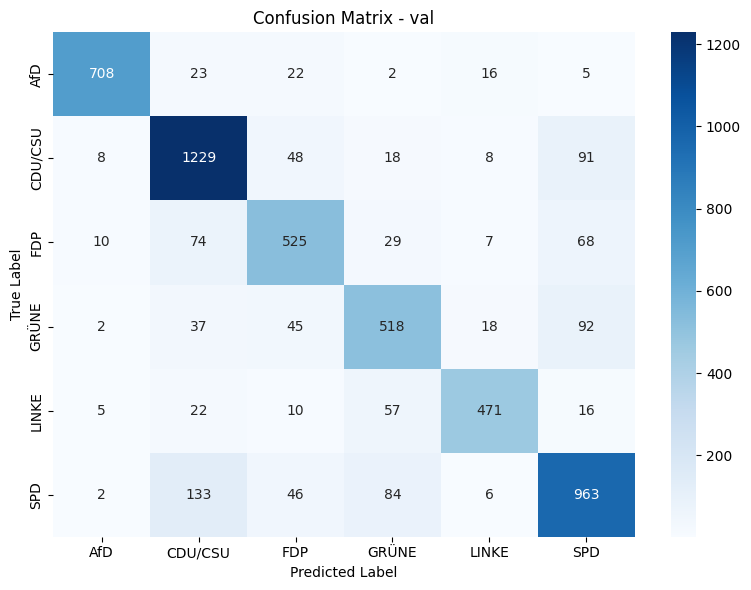

Model: test
  Accuracy: 0.8078626799557033
  Balanced Accuracy: 0.8022927359529778
  Precision: 0.8159714076235015
  Recall: 0.8022927359529778
  F1-score: 0.808204835709519
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.95      0.90      0.93       747
     CDU/CSU       0.82      0.86      0.84      1426
         FDP       0.71      0.76      0.74       678
       GRÜNE       0.76      0.71      0.73       804
       LINKE       0.89      0.80      0.84       593
         SPD       0.75      0.78      0.77      1170

    accuracy                           0.81      5418
   macro avg       0.82      0.80      0.81      5418
weighted avg       0.81      0.81      0.81      5418



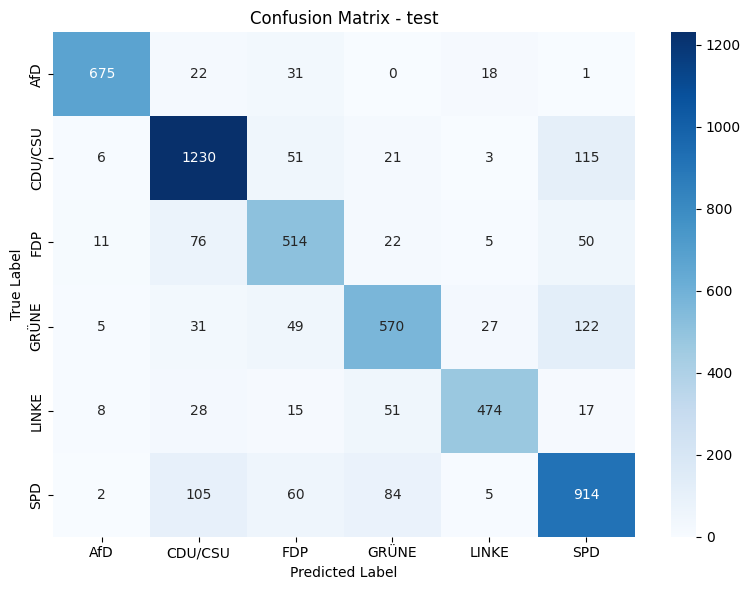

In [22]:
# define function to display eval metrics
def get_metrics(true_labels, preds, model_name):
    metrics_summary = {}

    acc = accuracy_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, preds)

    precision = precision_score(true_labels, preds, average='macro', zero_division=0)
    recall = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

    label_order = sorted(set(true_labels).union(set(preds)))
    report = classification_report(true_labels, preds, labels=label_order, zero_division=0)
    metrics_summary[model_name] = {
        'acc': acc,
        'bal_acc': bal_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    # print metrics
    print(f"Model: {model_name}")
    print(f"  Accuracy: {acc}")
    print(f"  Balanced Accuracy: {bal_acc}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Classification Report:\n{report}")


    # Confusion Matrix
    label_order = sorted(set(true_labels).union(set(preds)))
    cm = confusion_matrix(true_labels, preds, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


    return metrics_summary

val_results = get_metrics(results_val_A_df["label"], results_val_A_df["prediction_label"], "val")
test_results = get_metrics(results_test_A_df["label"], results_test_A_df["prediction_label"], "test")
